In [0]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib           
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

#Connections between Canadian Provinces
A = torch.tensor([[1,     1,     1,     0,     0,     0,     0,     0,     1,     0,     1,     1,     1],
                  [1,     1,     1,     0,     0,     1,     0,     0,     1,     0,     1,     1,     0],
                  [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
                  [0,     0,     0,     1,     1,     0,     0,     0,     1,     1,     1,     0,     0],
                  [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [0,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
                  [0,     0,     0,     0,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [0,     0,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
                  [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
                  [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
                  [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
                  [1,     0,     0,     0,     0,     1,     0,     1,     1,     0,     1,     0,     1]]);

#Number of connections each province has                  
L = torch.tensor([[6,    -1,    -1,     0,     0,     0,     0,     0,    -1,     0,    -1,    -1,    -1], 
                  [-1,    6,    -1,     0,     0,    -1,     0,     0,    -1,     0,    -1,    -1,     0],
                  [-1,    1,     7,     0,     0,    -1,     0,    -1,    -1,     0,    -1,    -1,     0],
                  [0,     0,     0,     4,    -1,     0,     0,     0,    -1,    -1,    -1,     0,     0],
                  [0,     0,     0,    -1,     5,     0,    -1,     0,    -1,    -1,    -1,     0,     0],
                  [0,    -1,    -1,     0,     0,     7,     0,    -1,    -1,     0,    -1,    -1,    -1],
                  [0,     0,     0,     0,    -1,     0,     4,     0,    -1,    -1,    -1,     0,     0],
                  [0,     0,    -1,     0,     0,    -1,     0,     6,    -1,     0,    -1,    -1,    -1],
                  [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    12,    -1,    -1,    -1,   -1],
                  [0,     0,     0,    -1,    -1,     0,    -1,     0,    -1,     5,    -1,     0,     0],
                  [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    12,    -1,   -1],
                  [-1,    -1,    -1,     0,     0,    -1,     0,    -1,    -1,     0,    -1,     7,    0],
                  [-1,     0,     0,     0,     0,    -1,     0,    -1,    -1,     0,    -1,     0,    5]]);



In [0]:
def SEImodel(theta,S,E,I):
    alpha = theta[0]
    beta  = theta[1]
    gamma = theta[2]
    mu    = theta[3]
    kE    = theta[4]
    kS    = theta[5]
    kI    = theta[6]
    

    dSdt  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
    dEdt  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    dIdt  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
    
    return dSdt, dEdt, dIdt




In [0]:
def integrateSEI(theta,S0,E0,I0,dt,nt):
    
    # vectors to save the results over time
    Sout = torch.zeros(nt+1); Sout[0] = S0
    Eout = torch.zeros(nt+1); Eout[0] = E0
    Iout = torch.zeros(nt+1); Iout[0] = I0
    
    S = S0; E = E0; I = I0
    for i in range(nt):
        dSdt, dEdt, dIdt = SEImodel(theta,S,E,I)
 

        S += dt*dSdt
        E += dt*dEdt
        I += dt*dIdt

        Sout[i+1] = S
        Eout[i+1] = E
        Iout[i+1] = I
       
    if I >= 0.05:
      print(S,E,I)
      return Sout, Eout, Iout
       
    return Sout, Eout, Iout
    


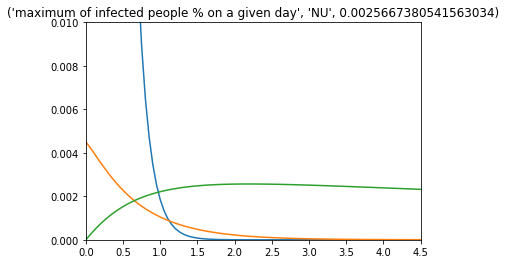

In [0]:
#NU Data as of March 22 2020
PopulationNU = 38780  #Census Canada
Recovered = 0          #Deceased -> it is impossible to tell if people who have recovered have returned to being infected
Infected = 0 - Recovered    #https://www150.statcan.gc.ca/n1/daily-quotidien/200428/dq200428a-eng.htm
Succeptible = PopulationNU - Infected
#Exposed -> true value is unknown -> assume 15% of those who are exposed are not sick

xmin = 0; xmax = 4.5;
ymin = 0; ymax = 0.01;

#April 30th highest amount of new infected (1) (first case),
S0 = Succeptible/PopulationNU
E0 = 0.0045
I0 = Infected/PopulationNU

# Set the duration for the simulation
dt = 0.05; nt = 100

# We pick the parameters as follows
alpha = .9       #rate of exposed people that get sick
beta  = .5       #rate of interaction of exposed and susceptible
gamma = .1       #rate of interaction infected and susceptible
mu    = 0.0       #rate of pepole who get resistence or die no people in NT has died as of yet...
kE    = 0.1       #Exposed people that move around
kS    = 0.9       #Susceptible people that move around
kI    = 0.01     #Sick people that move around (Diffusion of sick people)
theta = torch.tensor([alpha, beta, gamma, mu, kE, kS, kI])

P = ['AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']
for n in range(1):

  S, E, I = integrateSEI(theta,S0,E0,I0,dt,nt)

  t = np.arange(nt+1)*dt
  title = 'maximum of infected people % on a given day', P[7], torch.max(I).item()
  plt.figure(7)
  plt.title(title)
  plt.plot(t,S,t,E,t,I)

  axes = plt.gca()
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])

#because Nunavut only has one case its difficult to develop a curve... this graph predics that they could
#have a handful more before the pandemic is over however it is very hard to say as very little data is available

In [0]:
def ForwardEuler(alpha,beta,gamma,mu,kE,kS,kI,S0,E0,I0,dt,nt):  #Looks to be similar to integrateSEI
    
    S = torch.zeros(nt+1)
    E = torch.zeros(nt+1)
    I = torch.zeros(nt+1)
    S[0] = S0; E[0] = E0; I[0] = I0
    for i in range(nt):
        F = Model(alpha,beta,gamma,mu,kE,kS,kI,S[i],E[i],I[i])
        S[i+1] = S[i] + dt*F[0]
        E[i+1] = E[i] + dt*F[1]
        I[i+1] = I[i] + dt*F[2]
        
    return S, E, I

In [0]:
def Model(alpha,beta,gamma,mu,kE,kS,kI,S,E,I):  #Looks to be similar to SEImodel
    
    F = torch.zeros(3)
    F[0]  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
    F[1]  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    F[2]  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
    
    return F

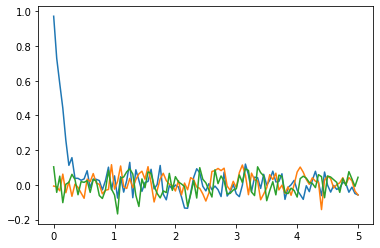

In [0]:
t = np.arange(nt+1); t = t*dt

# Add noise to the data
ndata = S.shape
nS = torch.randn(ndata[0])*0.05
nE = torch.randn(ndata[0])*0.05
nI = torch.randn(ndata[0])*0.05

Sobs = S+nS; Eobs = E+nE; Iobs = I+nI  #observed plus noise

# This is what we observe
plt.plot(t,Sobs) #make noise smaller to make the curves nicer
plt.plot(t,Eobs)
plt.plot(t,Iobs)

In [0]:
def loss(alpha,beta,gamma,mu,kE,kS,kI,Sobs,Eobs,Iobs,dt,nt):
    
    Scomp, Ecomp, Icomp = ForwardEuler(alpha,beta,gamma,mu,kE,kS,kI,S0,E0,I0,dt,nt) #comp is computed from code with a chosen beta, gamma 
    phi = torch.sum((Scomp-Sobs)**2) + torch.sum((Ecomp-Eobs)**2) + torch.sum((Icomp-Iobs)**2) #if comp and obs is the same then phi goes to zero
    
    return phi

In [0]:
print(loss(alpha,beta,gamma,mu,kE,kS,kI,S0,E0,I0,dt,nt))

tensor(95.7376)


In [0]:
theta

tensor([0.9000, 0.5000, 0.1000, 0.0000, 0.1000, 0.9000, 0.0100])

In [0]:
def SEImodel(theta,S,E,I):
    alpha = theta[0]
    beta  = theta[1]
    gamma = theta[2]
    mu    = theta[3]
    kE    = theta[4]
    kS    = theta[5]
    kI    = theta[6]
    

    dSdt  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
    dEdt  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    dIdt  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
    
    return dSdt, dEdt, dIdt

In [0]:
# Now we compute gradients
x = torch.tensor(theta, requires_grad=True)
Sg, Eg, Ig = SEImodel(x,S0,E0,I0)

Sg.backward()
Eg.backward()
Ig.backward()

gradSg = x.grad
gradEg = x.grad
gradIg = x.grad

print(gradSg)
print(gradEg)
print(gradIg)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.0270, -6.0000,  0.0000])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.0270, -6.0000,  0.0000])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.0270, -6.0000,  0.0000])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
